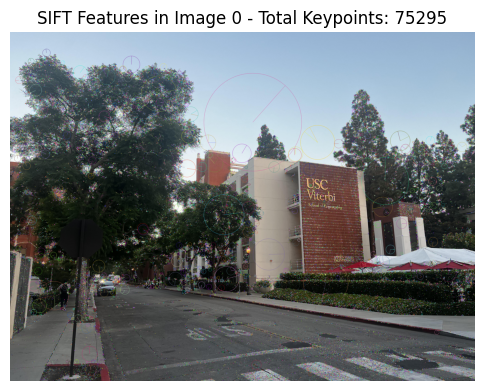

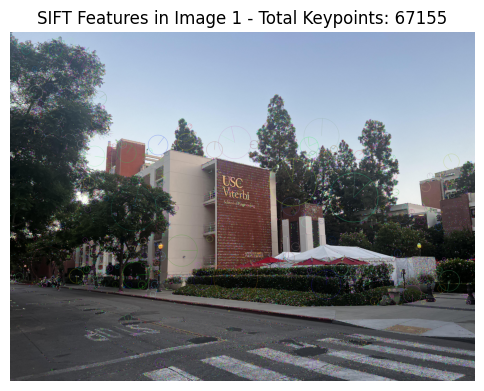

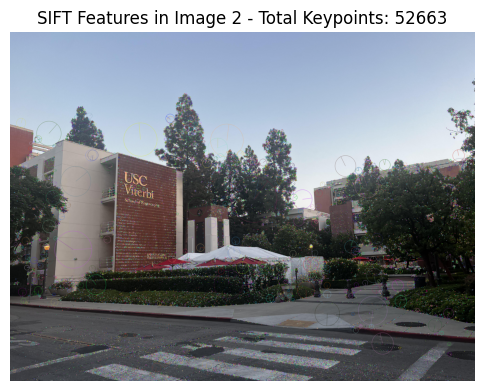

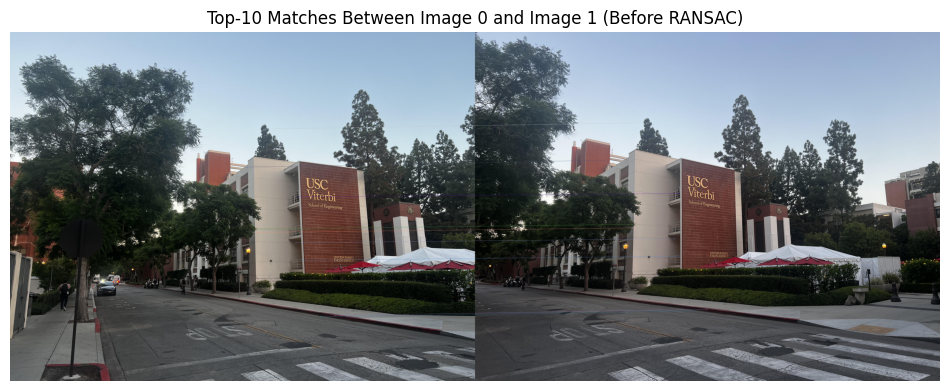

Number of good matches between Image 0 and Image 1: 9270
Homography Matrix Between Image 0 and Image 1:
[[ 6.87362583e-01  1.43128827e-02  9.13818524e+02]
 [-1.46249644e-01  8.51269765e-01  2.88649890e+02]
 [-7.33536359e-05 -9.43074176e-06  1.00000000e+00]]



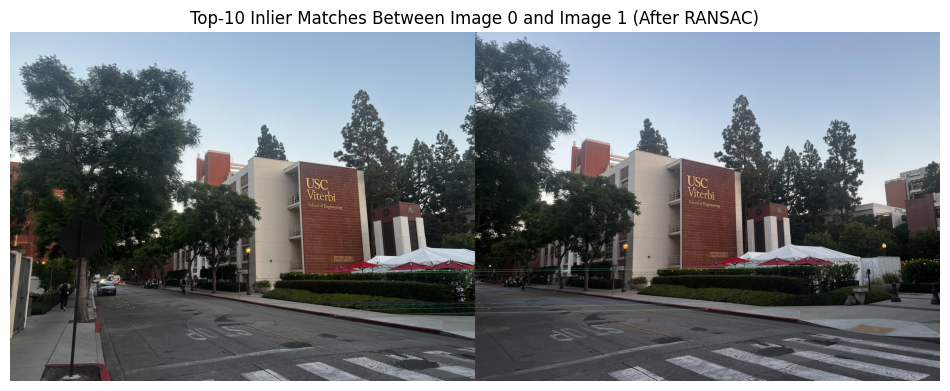

Number of inlier matches between Image 0 and Image 1: 4481


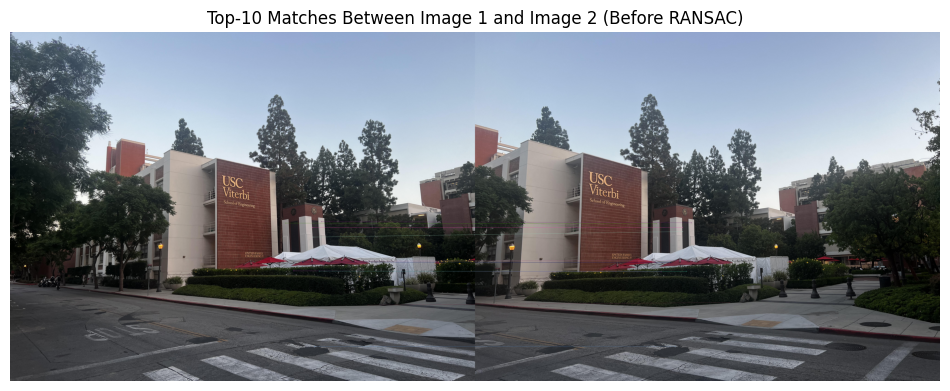

Number of good matches between Image 1 and Image 2: 8674
Homography Matrix Between Image 1 and Image 2:
[[ 6.22809781e-01  3.35150591e-02  1.01837368e+03]
 [-1.66677290e-01  8.52597473e-01  2.65188014e+02]
 [-9.15720865e-05  9.95550138e-07  1.00000000e+00]]



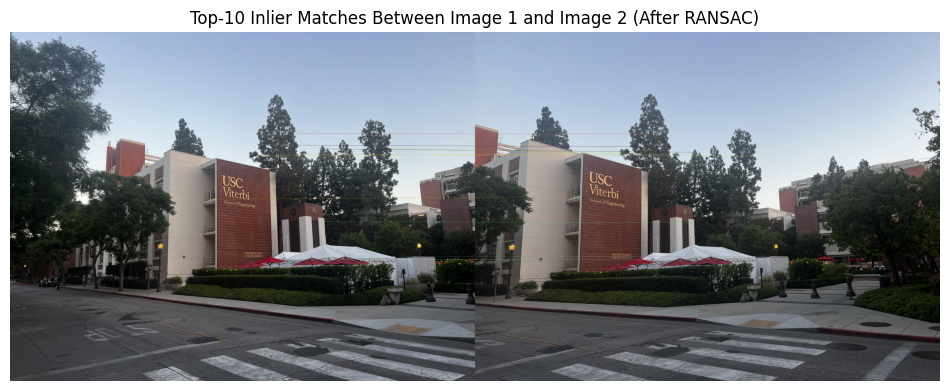

Number of inlier matches between Image 1 and Image 2: 3517
Output Canvas Bounds: min_x=0, min_y=-1811.1209716796875, max_x=8951.626953125, max_y=4324.1591796875
Output Canvas Size: width=8951, height=6135


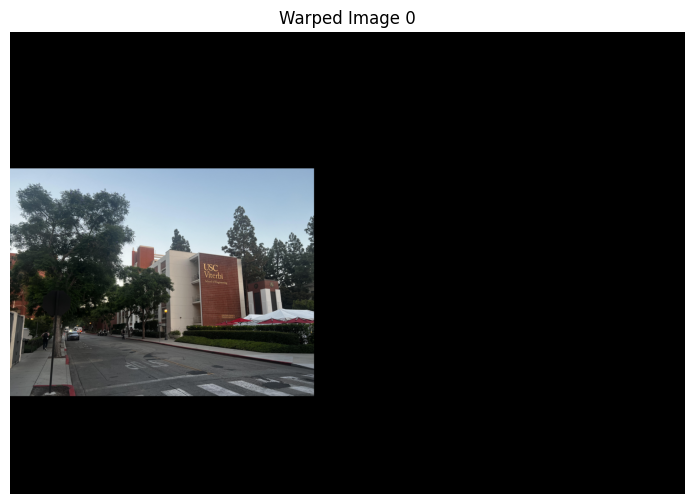

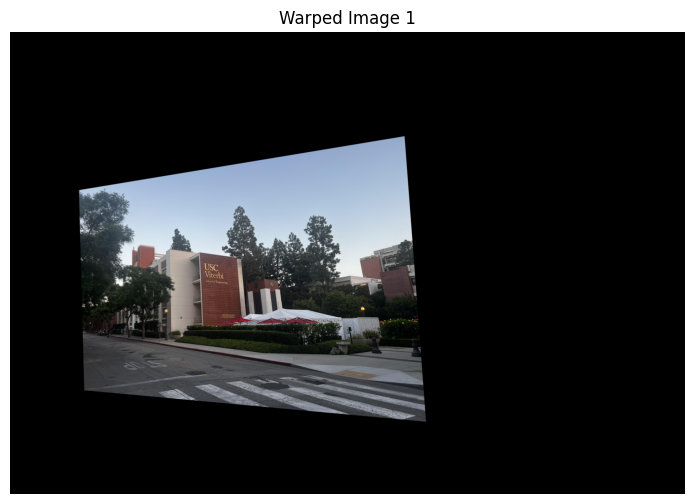

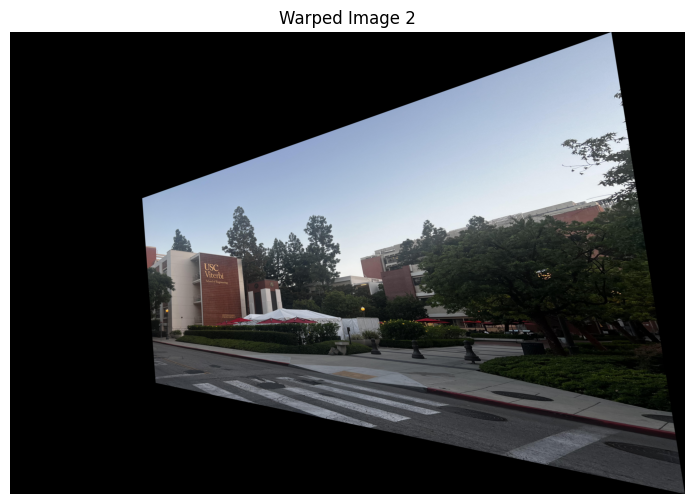

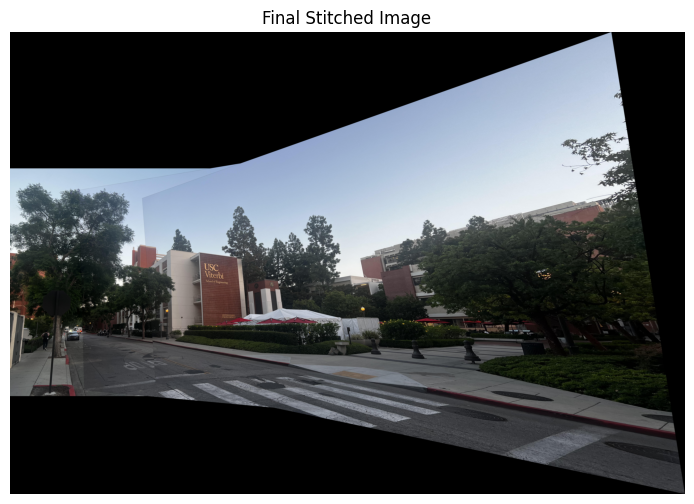

True

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load image paths and images
image_paths = ['../data/001.jpg', '../data/002.jpg', '../data/003.jpg']
images = [cv.imread(path) for path in image_paths]

# Convert to grayscale
grayscale_images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

# Detect SIFT keypoints and descriptors
sift = cv.SIFT_create()
keypoints_list = []
descriptors_list = []

for idx, gray_img in enumerate(grayscale_images):
    kpts, dpts = sift.detectAndCompute(gray_img, None)
    keypoints_list.append(kpts)
    descriptors_list.append(dpts)

    # Show keypoints overlaid on the image
    img_with_keypoints = cv.drawKeypoints(images[idx], kpts, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv.cvtColor(img_with_keypoints, cv.COLOR_BGR2RGB))
    plt.title(f'SIFT Features in Image {idx} - Total Keypoints: {len(kpts)}')
    plt.axis('off')
    plt.show()

# Initialize BFMatcher and Homography matrices
bf = cv.BFMatcher()
H_cumulative = np.eye(3, dtype=np.float32)
H_list = [H_cumulative]

# Match and compute homographies between consecutive images
for i in range(1, len(images)):
    # Match descriptors using BFMatcher with kNN
    matches = bf.knnMatch(descriptors_list[i - 1], descriptors_list[i], k=2)

    # Apply Lowe's ratio test to find good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Sort and show top-10 matches before RANSAC
    top_10_matches = sorted(good_matches, key=lambda x: x.distance)[:10]
    img_matches = cv.drawMatches(images[i - 1], keypoints_list[i - 1], images[i], keypoints_list[i], top_10_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
    plt.title(f'Top-10 Matches Between Image {i-1} and Image {i} (Before RANSAC)')
    plt.axis('off')
    plt.show()

    print(f"Number of good matches between Image {i-1} and Image {i}: {len(good_matches)}")

    # Extract the matching keypoints for homography calculation
    src_pts = np.float32([keypoints_list[i - 1][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_list[i][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute homography using RANSAC
    H, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)
    if H is None:
        print(f"Homography could not be computed between Image {i-1} and Image {i}")
        continue

    print(f"Homography Matrix Between Image {i-1} and Image {i}:\n{H}\n")

    # Show inlier matches after RANSAC
    inliers = mask.ravel() == 1
    inlier_matches = [good_matches[j] for j in range(len(good_matches)) if inliers[j]]
    top_10_inliers = sorted(inlier_matches, key=lambda x: x.distance)[:10]
    img_inlier_matches = cv.drawMatches(images[i - 1], keypoints_list[i - 1], images[i], keypoints_list[i], top_10_inliers, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv.cvtColor(img_inlier_matches, cv.COLOR_BGR2RGB))
    plt.title(f'Top-10 Inlier Matches Between Image {i-1} and Image {i} (After RANSAC)')
    plt.axis('off')
    plt.show()

    print(f"Number of inlier matches between Image {i-1} and Image {i}: {len(inlier_matches)}")

    # Update cumulative homography
    H_cumulative = H_cumulative @ H
    H_list.append(H_cumulative)

# Determine canvas size for final output
min_x = min_y = max_x = max_y = 0
for i in range(num_images):
    height, width = images[i].shape[:2]
    corners = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32).reshape(-1, 1, 2)
    transformed_corners = cv.perspectiveTransform(corners, H_list[i])
    min_x = min(min_x, transformed_corners[:, 0, 0].min())
    min_y = min(min_y, transformed_corners[:, 0, 1].min())
    max_x = max(max_x, transformed_corners[:, 0, 0].max())
    max_y = max(max_y, transformed_corners[:, 0, 1].max())

output_width = int(max_x - min_x)
output_height = int(max_y - min_y)

# Define translation to handle negative coordinates
translation_dist = [-min_x, -min_y]
translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]], dtype=np.float32)

print(f"Output Canvas Bounds: min_x={min_x}, min_y={min_y}, max_x={max_x}, max_y={max_y}")
print(f"Output Canvas Size: width={output_width}, height={output_height}")

# Initialize output canvas
output_canvas = np.zeros((output_height, output_width, 3), dtype=np.uint8)

# Warp and paste each image onto the canvas
for i in range(num_images):
    H_translated = translation_matrix @ H_list[i]
    warped_image = cv.warpPerspective(images[i], H_translated, (output_width, output_height))

    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
    plt.title(f'Warped Image {i}')
    plt.axis('off')
    plt.show()

    # Combine images, handling overlaps
    non_black_pixels = (warped_image > 0).any(axis=2)
    output_canvas[non_black_pixels] = warped_image[non_black_pixels]

# Show the final stitched image
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(output_canvas, cv.COLOR_BGR2RGB))
plt.title('Final Stitched Image')
plt.axis('off')
plt.show()

# Save the output
cv.imwrite('../data/stitched_output_combined.jpg', output_canvas)
